Spatial and spectral resolution are essential aspects of a raster. However, depending on the study area’s size, images with high spectral and spatial resolution can have large sizes that difficult to analyze the data even in high-end computers. In this competition, some of the rasters have around 42GB, which makes the visualization and the analysis of the data difficult. Moreover, the files are .ers files, which sometimes cannot be open by some GIS software. 

In this post, I will show some workarounds, using the Geopandas and Rasterio Python libraries, that can be done to work with huge rasters without a supercomputer. The idea is to help start analyzing the dataset and give insights about data`s pre-processing for future analysis with unsupervised machine learning algorithms.

The post comprises three parts:

The first part will show how to use the rasterio library to open the data using small windows and save the windowed data.

The second part will show how to generate a regular sampling grid to patch the images in a defined size and stack the bands on those smaller tiles.

The third part will show how to sample the images using random points and extract the pixel value of those points. 

 Visualizing the data using rasterio windows on an interactive Jupyter notebook
Ipywidgets library allows interactively visualizing data on Jupyter notebooks. Here we will load the peru100.ers image (100 meters resolution and 10 bands) using the rasterio.open() and rasterio.read() methods and create a function that will enable changing the x, y values of the window to load the data interactively. It`s also possible to change the displaying band interactively. The same process can be done with the 10 meters resolution raster. However, the file will have just one band in this case.

For that, we will use the following code :    

Check if you have all the following libraries installed.

In [1]:
# Import the libraries
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import pandas as pd
import geopandas as gpd
from scipy import ndimage
from shapely.geometry import box
from shapely.geometry import Point
import random
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
import os
from rasterio import plot
from rasterio.windows import Window
from ipywidgets import interact, interactive, fixed, interact_manual



In [4]:

# Define a function to allow changing the x,y and band parameters.
def f(x,y,band):
    # Open the image as src
    with rio.open("peru100/peru100.ers") as src:
        # read the image (conversion to array) with the window parameter
        # The window parameter accepts the Window class
        # the first two numbers are the x and y pixel points
        # and the other two numbers are the width (512) and height (256) of the window
        w = src.read(band,window=Window(x,y,512,256))
        # return the plot of the image with the title showing the band value
    return plot.show(w,title=f"band: {band}",cmap="Greys")
# run the interactive function
interact(f, x=(0,2000), y=(0,2000),band=(1,10))


interactive(children=(IntSlider(value=1000, description='x', max=2000), IntSlider(value=1000, description='y',…

<function __main__.f(x, y, band)>

In the following post by Neil Pendock (https://unearthed.solutions/u/competitions/90/forum#/question/df9de9f4-ebd7-452d-8cc0-113f9eeaf983), he shows some band ratios that may help in the interpretation of the data. So, let`s include some ratios in our interactive plot. 

In [5]:
# You can also make the band ratios on-the-fly
# ignore the 0 division error
np.seterr(divide='ignore', invalid='ignore')
# define an interactive funtion
def f(x,y,band1,band2):
    with rio.open("peru100/peru100.ers") as src:
        w = src.read(band1,window=Window(x,y,512,256))
        z = src.read(band2, window=Window(x,y,512,256))
        # Define the ratio - you can change this for different ratios
        ratio = w/z
    return plot.show(ratio,title=f"band: {band1}/{band2}",cmap="plasma")
# show the interactive plot 
interact(f,x=(0,2000),y=(0,2000),band1=(1,10),band2=(1,10))

interactive(children=(IntSlider(value=1000, description='x', max=2000), IntSlider(value=1000, description='y',…

<function __main__.f(x, y, band1, band2)>

I`ve changed the "cmap" attribute to plasma this time. You can trie other color maps following the matplotlib documentation. 

After exploring the data, if you get interested in a specific area, it`s possible to save the windowed part as a .tif file to open in any GIS software. Just remember to change the metadata of your file accordingly. 

In [6]:
# open the image
with rio.open("peru100/peru100.ers") as src:
    # read the fist band using a window with height 256 and width 512 starting at pixel 0,0
    w = src.read(1,window=Window(0,0,512,256))
    # create a variable to store the metadata
    meta = src.meta.copy()
    # update the metadata from .ers to tif
    meta["driver"] = "GTIFF"
    # update the number of bands to 1
    meta["count"] = 1
    # update the height and the width
    meta["height"] = 256
    meta["width"] = 512
    # Create a folder to save the results
    savePath =  "pre_processing/windowed_data"
    if not os.path.exists(savePath):
                        os.makedirs(savePath)
    # save the .tif image
    with rasterio.open(f"{savePath}/widowed_data.tif", 'w', **meta) as dst:
        dst.write(np.expand_dims(w,0),window=Window(0,0,512,256))

    2. Regular sampling and patching the data 

Before creating the regular sampling grid, we will generate a polygon of the area to select only the study area’s sampling polygons. For that, we will first create a binary image that will have that shape of the area; later, we will vectorize this image using the feature module of the rasterio library and save the vector as a GeoJSON polygon using geopandas library.

Let`s define the function convert_to_binary() to create binary image for us. This function will change all the pixel values that are greater than one to one and also fill some of the roles (due to the pixels with value 0 present in the raster) inside the study area.

In [10]:
# First we will create a binary mask of the area that will be used to create a shapefile with the shape of the study area
def convert_to_binary(imagePath,savePath, saveName):
    """
    Function to convert a raster into a binary file. 
    
    Parameters:
    
    imagePath(string): path to the raster
    savePath(string): path to save the binary raster
    saveName(string): name of the saved file
    """
    # open the image
    tifImage = rio.open(imagePath)
    # load the metadata
    meta = tifImage.meta
    # updated the metadata
    meta["count"] = 1
    meta["nodata"] = None
    meta["dtype"] = "uint8"
    meta["driver"] = "GTiff"
    # convert data to uint8
    tifImage = tifImage.read(1).astype("uint8")
    # change all the pixels with value different from 0 to 1
    tifImage[tifImage != 0] = 1
    # closse the roles inside the image
    tifImage = ndimage.binary_closing(tifImage).astype("uint8")
    # expand the 0 dim to save the image according to rasterio dimensions
    save = np.expand_dims(tifImage,axis = 0)
    # create the save folder
    if not os.path.exists(savePath):
                        os.makedirs(savePath)
    # save the binary image
    with rio.open(f"{savePath}/{saveName}.tif","w",**meta) as dst:
        dst.write(save)


In [11]:
# run the function
convert_to_binary("peru100/peru100.ers","pre_processing/binary_image",
               "binary_image_peru_area")

Now we will vectorize the binary image using the vectorize_binary_image() function, the result is a GeoJSON file.

In [15]:
# Now we will define a function to vectorize the binary image
def vectorize_binary_image(imagePath, savePath, saveName, save=True):
    """
    Function to convert the binary raster into a vector file (GeoJSON).
    
    Parameters:
    
    imagePath(string): path to the binary raster;
    savePath(string): path to save the GeoJSON file;
    saveName(string): name of the saved GeoJSON file;
    save(bool): True if want to save the file
    
    return:
    save == False => geopandas.GeoDataFrame;
    """
    # load the image
    with rio.open(imagePath) as src:
        # variable that will contain the generated polygons
        results = ({'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(shapes(src.read(), transform=src.transform)))
        # Create a list from the results that looks like a geojson features file
        geoms = list(results)
        # create a geodataframe from the feature files
        gdf  = gpd.GeoDataFrame.from_features(geoms)
        # We will use just the raster values that have the value 1
        gdf = gdf[gdf["raster_val"] == 1]
        if save:
            if not os.path.exists(savePath):
                        os.makedirs(savePath)
                    
            gdf.to_file(f"{savePath}/{saveName}.geosjon",driver="GeoJSON")
        else:
            return gdf

In [16]:
# run the function
vectorize_binary_image(imagePath="pre_processing/binary_image/binary_image_peru_area.tif",savePath="pre_processing/vector_area",
                       saveName="vector_peru")
                

We will create a class (SampleShapefile) with the generate_regular_grid method to generate the regular sampling grid. This method accepts five parameters: the “xsize” and “ysize” parameters corresponds to the size in pixels of the polygons squares that will be generated.  “Overlap” can be used if you want the grid to have some amount of overlap between the polygons (we will use 0 as overlap in this post). “Save” can be set to true if you want to save the resulting geojson in a folder and “savePath” is the folder to save the file.

In [20]:
# Now we will generate a regular sampling grid over the image to patch the images
class SampleShapefile():
    """
    Class SampleShapeFile:
    
    Attributes:
    imagepath (string) = path to the .tif image;
    
    Methods:
    generateShapefileRandomGrid => (geopandas.GeoDataFrame) 
    generateShapefileRegularGrid =>(geopandas.GeoDataFrame)
    
    """
    def __init__(self,pathToImage):
        # Define the imagepath variable with the path to the .tif image
        self.imagepath = pathToImage
        # Define the class atribute the image varible that opens the .tif image
        self.image = rio.open(self.imagepath)
        # Get the metadata, crs and bounds of the TifImage
        with self.image as TifImage:
            self.meta = TifImage.meta
            print("Class Created!")
            self.crs = TifImage.crs
            self.xmax = TifImage.bounds[2]
            self.xmin = TifImage.bounds[0]
            self.ymax = TifImage.bounds[3]
            self.ymin = TifImage.bounds[1]
    
    
    def generateShapefileRegularGrid(self,xsize, ysize, overlap=0,save = False, savePath = None):
        """
        # Code addapted from Keras-spatial library - https://pypi.org/project/keras-spatial/ 
        Generate regular grid over extent.
        Args:
          xmin (float): extent left boundary
          ymin (float): extent bottom boundary
          xmax (float): extent right boundary
          ymax (float): extent top boundary
          xsize (float): patch width
          ysize (float): patch height
          overlap (float): percentage of patch overlap (optional)
          crs (CRS): crs to assign geodataframe 
        Returns:
            if save == false:
              
            else:
                geopandas.GeoDataFrame:
        """
        #Define the pixel size and multiply by the xsize to get xsize in number of pixels
        xsize = (self.meta["transform"][0]*(xsize-1)) 
        ysize = ((-self.meta["transform"][4])*(ysize-0.5))
        
        
    

        x = np.linspace(self.xmin, self.xmax-xsize, num=int((self.xmax-self.xmin)//(xsize-xsize*overlap)))
        y = np.linspace(self.ymin, self.ymax-ysize, num=int((self.ymax-self.ymin)//(ysize-ysize*overlap)))
        X,Y = np.meshgrid(x, y)
        polys = [box(x, y, x+xsize, y+ysize) for x,y in np.nditer([X,Y])]

        gdf = gpd.GeoDataFrame({'geometry':polys})
        gdf.crs = self.crs
        if save == False:
            return gdf
        else:
            if not os.path.exists(savePath):
                        os.makedirs(savePath)
            gdf.to_file(f"{savePath}/regular_grid.geojson", driver="GeoJSON")
    

We will first create the instance of the class and save it in the variable “sample”. Note that you need to pass the image path as the parameter. We will use the sentinel_2.ers file.

In [21]:
# Create an instance of the SampleShapefile class
sample = SampleShapefile("mosaic2/sentinel_2.ers")

Class Created!


The variable “shape” will receive the sampling shapefiles returned by the generate_regular_grid() method. We will generate 4000x4000 pixels grid. As we can see, the grid was created over the raster area; thus, there are a lot of areas with only 0-pixel values that we don`t want to consider. That`s why we generated the study area polygon; now, we can use a spatial join operation to select only the polygons that intersect Peru`s region. 

In [22]:
# Use the generate_regular_grid method to generate a regular grid with the tiles with 512x512 pixels
shape = sample.generateShapefileRegularGrid(4000,4000,0)

In [23]:
# load the study area vector
study_area = gpd.read_file("pre_processing/vector_area/vector_peru.geosjon")
# spatial join to select only the shapes that intersect the study area
spatial_join = gpd.sjoin(shape,study_area)

# save sampling GeoJSON
savePath = "pre_processing/sampling"
if not os.path.exists(savePath):
                        os.makedirs(savePath)
spatial_join.to_file(f"{savePath}/sampling_area.geosjon", driver = "GeoJSON")

Great, now we have only the polygons intersects the study area (figure below). Therefore, let`s define a function to patch the images based on those polygons. 

The patchImage will use the polygons to crop the image. There are six parameters in this function which are described in the comments below the function. It will take some time to patch the image. Thus, I will only show here the process of patching the first three (RGB) bands.

In [24]:
def patchImage(shapefilePath, imagePath,savePath, fileName, save = False):
    """
    Function that use polygons to patch the image.
    
    Parameters:
    
    shapefilePath (string): path to the .shp or geojson file with the polygons that will patch the image.
    
    imagePath (string): path to the image.
    
    fileName (string): name of the output file.
    
    save(bool): True if you want to save the data
    
    Return (if save = false)
    
    (np.array) image
    
    """
    images = []
    non_32 = []
    #Load the shapefile
    with fiona.open(shapefilePath, "r") as shapefile:
        #Generate a list with the geometry of the shapes
        shapes = [feature["geometry"] for feature in shapefile]
        print(f"There are {len(shapes)} polygons to patch the image.")
    with rasterio.open(imagePath) as src:
        for i in range(len(shapes)):
            #patch the image based on the shapefile
            out_image, out_transform = rasterio.mask.mask(src, [shapes[i]], crop=True, filled=False)
            #Get the metadata of the crop
            out_meta = src.meta
            if save == True:
            # if want to save the tiles
                out_meta.update({"driver": "GTiff", "height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
                with rasterio.open(f"{savePath}/{fileName}_{str(i)}.tif", "w", **out_meta) as dest:
                    dest.write(out_image)
                    print(f"{fileName}_{str(i)}.tif Saved!")
            
    print(f"Done! Images saved on {savePath}")
    if save == False:
        image = np.array(images, dtype = "float32")
        return image

In [25]:
# list of the image paths - add the paths to all bands here to patch all rasters.
paths = ["mosaic2/sentinel_2.ers","mosaic3/sentinel_3.ers",
        "mosaic4/sentinel_4.ers"]
# loo over all image paths
for i, path in enumerate(paths):
    # get the band to create a folder with the band name
    band = path.split("_")[-1].split(".")[-2]
    savePath = f"pre_processing/patch_images/band_{band}"
    if not os.path.exists(savePath):
                        os.makedirs(savePath)
    # patch the images
    patchImage(shapefilePath="pre_processing/sampling/sampling_area.geosjon",imagePath=path,savePath=savePath,fileName="tile", save=True)

There are 515 polygons to patch the image.


KeyboardInterrupt: 

After patching the images, we will stack the three bands to generate an RGB image. Here I will show the process for only one of the tiles (tile_2.tif), but you can easily implement a loop to do it for all the tiles.

In [134]:
# After patching the image of each band it's possible to use rasterio to stack the bands, here I will show 
# an example with bands 2 (blue) and band 3 (green) and band 4 (red), the same process can be repeated for the other
# bands 

# load each band
band2 = rio.open(f"pre_processing/patch_images/band_2/tile_2.tif")
band3 = rio.open(f"pre_processing/patch_images/band_3/tile_2.tif")
band4 = rio.open(f"pre_processing/patch_images/band_4/tile_2.tif")

# update the metadata to include 3 bands
band2_geo = band2.profile
band2_geo.update({"count": 3})

# create the folder to save the files
savePath = "pre_processing/patch_images/rgb"
if not os.path.exists(savePath):
                        os.makedirs(savePath)

with rasterio.open(f'{savePath}/rgb.tif', 'w', **band2_geo) as dest:
# I rearanged the band order writting to 2→3→4 instead of 4→3→2
    dest.write(band2.read(1),1)
    dest.write(band3.read(1),2)
    dest.write(band4.read(1),3)

Now if you load the rgb.tif image in QGIS we can see that we have a true-color image of the tile_2.

  3. Generate random sampling points over the study area and extract the pixel value

If you think that patching or windowing the images takes too long, there is also another way to work with the dataset: generating random sampling points over the study area and extracting the pixel value of those points. For that, we will use the vector that was generated in the last step and generate the points inside the polygon. Here we will generate only 1000 points to show how it works. Some of the points will be created outside the desired area, that`s why we use the spatial join operation again. 

In [30]:
import geopandas as gpd
import numpy as np
# load the study area vector
area = gpd.read_file("pre_processing/vector_area/vector_peru.geosjon")
# get the shape bounds
x_min, y_min, x_max, y_max = area.total_bounds
# set sample size
n = 1000
# generate random data within the bounds
x = np.random.uniform(x_min, x_max, n)
y = np.random.uniform(y_min, y_max, n)
# convert them to a points GeoSeries
gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x, y))
# only keep those points within polygons
gdf_points = gpd.sjoin(gdf_points,area,op="within")

# create the folder to save the file
savePath = "pre_processing/sampling_points"
if not os.path.exists(savePath):
                        os.makedirs(savePath)
# save the points to geojson file
gdf_points.to_file(f"{savePath}/sampling_points_{n}.geojson", driver="GeoJSON")

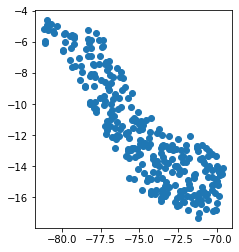

In [31]:
gdf_points.plot()

To extract the values of the pixel on those points we will read the data using that windows (similar to the beginning of this post) but we will use the sampling points to create those windows, and also save the values on a dictionary that can be converted to a pandas DataFrame. 

First, we will create the function to create the tiny window around the sampling point.

In [140]:
# Create a tiny window from a point
def tiny_window(dataset, x, y):
    """
    Create a tiny window around the sampling point
    
    dataset(rasterio.io.DatasetReader) : raster that will be loaded using a window.
    x (float): coord x
    y (float): coord y
    """
    # get the row and column of the point on the image
    r, c = dataset.index(x, y)
    return ((r, r+1), (c, c+1))


Then we will use rasterio to open the rasters and extract the pixel value. Here we will use only the first three bands, but it`s simple to change the code to use all the bands available.

In [143]:
# load the sampling points
df = gpd.read_file("pre_processing/sampling_points/sampling_points_1000.geojson")
# dictinary that will contain the pixel value of the points
# here i will use just 3 bands (2,3,4). Add more key if you want to sample all the bands
point_value = {"band_2":[],"band_3":[],"band_4":[]}
# path to the images. Add more path if you want to sample all the rasters
paths = ["/Volumes/SEAGATE/competition/peru/dados/mosaic2/sentinel_2.ers","/Volumes/SEAGATE/competition/peru/dados/mosaic3/sentinel_3.ers",
        "/Volumes/SEAGATE/competition/peru/dados/mosaic4/sentinel_4.ers"]
# loop over all paths
for path in paths:
    # open the image
    with rio.open(path) as raster:
        # Get pixel coordinates from map coordinates
        for point in df["geometry"]:
            x = point.xy[0][0]
            y = point.xy[1][0]
            px, py = raster.index(x,y)
            #read the data using the tiny_window function
            data = raster.read(window=tiny_window(raster, x, y))
            # get the band from the path name
            band = path.split("_")[-1].split(".")[-2]
            # add the value in the dictionary
            point_value[f'band_{band}'].append(data[:,0,0][0])

Now we just need to convert the dictionary into a pandas Dataframe and we will have a table with the pixel value of the sampling points.

In [210]:
import pandas as pd

df = pd.DataFrame(point_values)

,band_2,band_3,band_4
0,1720,2210,2620
1,604,932,1222
2,763,1002,1262
3,1688,2098,2548
4,766,978,655
...,...,...,...
291,467,709,855
292,633,979,1294
293,412,655,902
294,739,1086,1512


This result can be used for unsupervised machine learning analysis such as PCA, clustering, SOM.

This post shows how I am working with the data and how to address huge datasets to work without a supercomputer. As a geologist working with huge datasets is a common task, however, sometimes we need to avoid large files to allow faster processing. This was the main goal of this workflow.    